In [1]:
# Импортируем нужные библиотеки:

import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.base import clone

# Функции

In [2]:
# Напишем функцию, определяющую уникален элемент или нет (всем уникальным присваивает значение True, не уникальным False)
def unique_or_not(x):
    x.value_counts()
    counter = 0
    for i in range (0, len(x.value_counts())):
        if x.value_counts()[i] > 1:
            counter = counter+1
        else:
            break
    
    not_unique = x.value_counts()[0:counter].index.tolist()
    
    for i in range (0, len(x)):
        for j in range (0, len(not_unique)):
            if x[i] == not_unique[j]:
                x[i] = False
            else:
                x[i] = x[i]
    
    for i in range (0, len(x)):
        if x[i] != False:
            x[i] = True
        else:
            x[i] = x[i]
    

In [3]:
#запишем функцию для вычисления итоговой метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Данные.

In [4]:
# Импортитуем данные с которыми нам предстоит работать
data = pd.read_csv('D:\Data Scientist_Skill Factory\Folders with data/Unit_7/Project/test.csv') # Тестовый набор

In [5]:
train = pd.read_csv('D:\Data Scientist_Skill Factory\Folders with data/Unit_7/Project/cars_df.csv') # Обучающая выборка

C:\Users\vsevo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33531 entries, 0 to 33530
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              33531 non-null  object
 1   brand                 33531 non-null  object
 2   car_url               33531 non-null  object
 3   color                 33531 non-null  object
 4   description           33531 non-null  object
 5   engineDisplacement    33531 non-null  object
 6   enginePower           33531 non-null  object
 7   fuelType              33531 non-null  object
 8   image                 33531 non-null  object
 9   mileage               33531 non-null  object
 10  modelDate             33531 non-null  int64 
 11  model_name            33531 non-null  object
 12  name                  33531 non-null  object
 13  numberOfDoors         33531 non-null  int64 
 14  priceCurrency         33531 non-null  object
 15  productionDate        33531 non-null

In [8]:
sample_submission = pd.read_csv('D:\Data Scientist_Skill Factory\Folders with data/Unit_7/Project/sample_submission.csv') 
# Образец как записать результат

In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sell_id  34686 non-null  int64
 1   price    34686 non-null  int64
dtypes: int64(2)
memory usage: 542.1 KB


In [10]:
(sample_submission.sell_id == data.sell_id).value_counts()

True    34686
Name: sell_id, dtype: int64

# Описание признаков в тестовом наборе данных.

# Первичный осмотр данных.

In [11]:
train.shape

(33531, 25)

In [12]:
data.shape

(34686, 32)

In [13]:
test = data.drop(['complectation_dict', 'equipment_dict', 'model_info', 
                  'model_info', 'parsing_unixtime', 'super_gen', 'vendor', 'Владение'], axis=1)

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   description           34686 non-null  object
 5   engineDisplacement    34686 non-null  object
 6   enginePower           34686 non-null  object
 7   fuelType              34686 non-null  object
 8   image                 34686 non-null  object
 9   mileage               34686 non-null  int64 
 10  modelDate             34686 non-null  int64 
 11  model_name            34686 non-null  object
 12  name                  34686 non-null  object
 13  numberOfDoors         34686 non-null  int64 
 14  priceCurrency         34686 non-null  object
 15  productionDate        34686 non-null

In [15]:
test.shape

(34686, 25)

In [16]:
test['price'] = 0.0

In [17]:
test.shape

(34686, 26)

In [18]:
# Сделаем столбец test['sell_id'] последним в датасете
sell_id = test['sell_id'] 
test = test.drop(['sell_id'], axis=1)
test['sell_id'] = sell_id
# Для возможности объединения train и test добавим в train столбец train['sell_id'] и заполним нулями.
train['sell_id'] = 0

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33531 entries, 0 to 33530
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              33531 non-null  object
 1   brand                 33531 non-null  object
 2   car_url               33531 non-null  object
 3   color                 33531 non-null  object
 4   description           33531 non-null  object
 5   engineDisplacement    33531 non-null  object
 6   enginePower           33531 non-null  object
 7   fuelType              33531 non-null  object
 8   image                 33531 non-null  object
 9   mileage               33531 non-null  object
 10  modelDate             33531 non-null  int64 
 11  model_name            33531 non-null  object
 12  name                  33531 non-null  object
 13  numberOfDoors         33531 non-null  int64 
 14  priceCurrency         33531 non-null  object
 15  productionDate        33531 non-null

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   car_url               34686 non-null  object 
 3   color                 34686 non-null  object 
 4   description           34686 non-null  object 
 5   engineDisplacement    34686 non-null  object 
 6   enginePower           34686 non-null  object 
 7   fuelType              34686 non-null  object 
 8   image                 34686 non-null  object 
 9   mileage               34686 non-null  int64  
 10  modelDate             34686 non-null  int64  
 11  model_name            34686 non-null  object 
 12  name                  34686 non-null  object 
 13  numberOfDoors         34686 non-null  int64  
 14  priceCurrency         34686 non-null  object 
 15  productionDate     

# Предобработка данных

Проверим оба набора данных на дубликаты по адресу страницы с объявлением.

In [21]:
len(test)

34686

In [22]:
len(test.car_url.value_counts())

34686

In [23]:
len(train)

33531

In [24]:
len(train.car_url.value_counts())

33531

In [25]:
test['dataset_mark'] = 0 # Помечаем строки, относящиеся к датасету test нулем.
train['dataset_mark'] = 1 # Помечаем строки, относящиеся к датасету train единицей.

In [26]:
# Перед объединением test и train приведем значения в столбце train.price к float.

#Почистим данные
train['price'] = train['price'].apply(lambda x: str(x).replace('\xa0₽', ''))

train['price'] = train['price'].apply(lambda x: str(x).replace('\xa0', ''))

train['price'] = train.price.apply(
    lambda x: int("".join(filter(str.isdigit, x))))

# Переведем цены в формат float.
for i in range (0, len(train)):
    train.price[i] = float(train.price[i])

<ipython-input-26-cf21861a9cea>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.price[i] = float(train.price[i])


In [27]:
# Объединим обучающую и тестовую выборку в одну.
united = test.append(train, ignore_index = True)# Параметр ignore_index отвечает за нумерацию в объединенном датасете
# (сквозная или раздельная).

Проверим объединенный набор данных на дубликаты по адресу страницы с объявлением.

In [28]:
len(united)

68217

In [29]:
len(united.car_url.value_counts())

65609

Дубликаты имеются. Удалим их.

In [30]:
united.drop_duplicates(subset = 'car_url', keep = 'first', inplace = True)

In [31]:
united.shape # Убедимся, что дубликаты действительно удалены.

(65609, 27)

# Выполним разведывательный анализ данных.

In [32]:
# Создадим три списка признаков, и каждый признак будем добавлять в один из них.
# Бинарные
bin_cols = []
# Числовые
num_cols = []
# Категориальные
cat_cols = []

## Столбец bodyType (тип кузова).

In [33]:
# Проверим столбец на наличие пропусков.
united.bodyType.isna().value_counts()

False    65609
Name: bodyType, dtype: int64

In [34]:
display(united.bodyType.value_counts())
display(len(united.bodyType.value_counts()))

внедорожник 5 дв.          24589
седан                      23849
хэтчбек 5 дв.               4215
лифтбек                     4159
универсал 5 дв.             2319
минивэн                     1710
купе                        1499
компактвэн                   900
хэтчбек 3 дв.                829
пикап двойная кабина         482
купе-хардтоп                 285
внедорожник 3 дв.            203
фургон                       195
родстер                      166
кабриолет                    126
седан-хардтоп                 29
микровэн                      16
пикап одинарная кабина         9
пикап полуторная кабина        7
седан 2 дв.                    6
лимузин                        6
внедорожник открытый           4
фастбек                        2
тарга                          2
хэтчбек 4 дв.                  1
универсал 3 дв.                1
Name: bodyType, dtype: int64

26

<AxesSubplot:>

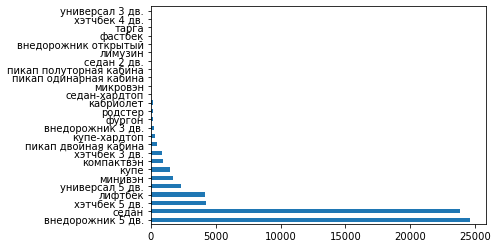

In [35]:
#посмотрим на распределение
united.bodyType.value_counts().plot.barh() 

In [36]:
cat_cols.append('bodyType') # Признак категориальный, добавим в соответствующий список

## Столбец brand (марка автомобиля).

In [37]:
# Проверим столбец на наличие пропусков.
united.brand.isna().value_counts()

False    65609
Name: brand, dtype: int64

In [38]:
display(united.brand.value_counts())
display(len(united.brand.value_counts()))

BMW           8137
VOLKSWAGEN    8106
NISSAN        7793
MERCEDES      7781
TOYOTA        7445
              ... 
MCLAREN          1
ZOTYE            1
MG               1
GAC              1
DAIHATSU         1
Name: brand, Length: 70, dtype: int64

70

In [39]:
cat_cols.append('brand') # Признак категориальный, добавим в соответствующий список

## Столбец car_url (адрес страницы с объявлением)

In [40]:
# Проверим столбец на наличие пропусков.
united.brand.isna().value_counts()

False    65609
Name: brand, dtype: int64

## Столбец color (цвет автомобиля).

In [41]:
# Проверим столбец на наличие пропусков.
united.color.isna().value_counts()

False    65609
Name: color, dtype: int64

In [42]:
display(united.color.value_counts())
display(len(united.color.value_counts()))

чёрный         20414
белый          12474
серый           8122
серебристый     6977
синий           6171
коричневый      3012
красный         2928
зелёный         1605
бежевый         1205
голубой          830
золотистый       448
пурпурный        443
фиолетовый       362
жёлтый           341
оранжевый        259
розовый           18
Name: color, dtype: int64

16

<AxesSubplot:>

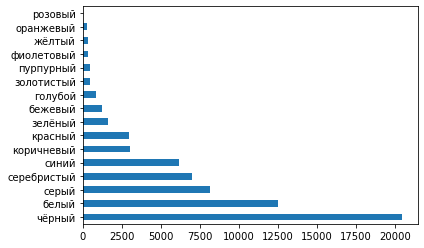

In [43]:
#посмотрим на распределение
united.color.value_counts().plot.barh() 

In [44]:
cat_cols.append('color') # Признак категориальный, добавим в соответствующий список

## Столбец description (описание автомобиля).

In [45]:
# Проверим столбец на наличие пропусков.
united.description.isna().value_counts()

False    65609
Name: description, dtype: int64

In [46]:
united.description = united['description'].apply(lambda x: len(x)) # заменили значения
united.rename(columns={'description': 'description_length'}, inplace=True) # переименовали столбец

In [47]:
num_cols.append('description_length') # Признак числовой, добавим в соответствующий список

## Столбец engineDisplacement (объем двигателя).

In [48]:
# Проверим столбец на наличие пропусков.
united.engineDisplacement.isna().value_counts()

False    65609
Name: engineDisplacement, dtype: int64

In [49]:
united.engineDisplacement = united['engineDisplacement'].apply(lambda x: x.split(' ') ) # заменили значения

In [50]:
united.engineDisplacement = united['engineDisplacement'].apply(lambda x: x[0])  # заменили значения

In [51]:
# Записываем в отдельную переменную датасет с машинами с электродвигателем.
temp_electro = united[(united.fuelType == 'электро')]
# Записываем в отдельную переменную датасет с машинами с двигателем внутреннего сгорания.
temp_traditional = united[(united.fuelType != 'электро')]
# Для машин с двигателем внутреннего сгорания заменяем строковые значения объема двигателя числовыми
temp_traditional.engineDisplacement = temp_traditional['engineDisplacement'].apply(lambda x: float(x))
# Для машин с электродвигателем присваиваем значения объема двигателя 0.0.
temp_electro.engineDisplacement = temp_electro['engineDisplacement'].apply(lambda x: 0.0)
# Объединяем датасеты в один.
united = temp_electro.append(temp_traditional, ignore_index = True)

C:\Users\vsevo\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


count    65609.000000
mean         2.383141
std          0.959896
min          0.000000
25%          1.600000
50%          2.000000
75%          3.000000
max          6.800000
Name: engineDisplacement, dtype: float64

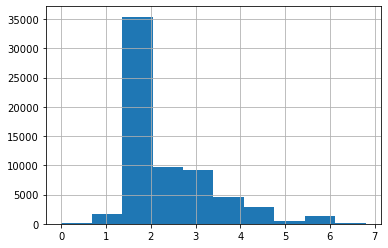

In [52]:
united.engineDisplacement.hist()
united.engineDisplacement.describe()

In [53]:
num_cols.append('engineDisplacement') # Признак числовой, добавим в соответствующий список

## Столбец enginePower (мощность двигателя).

In [54]:
# Проверим столбец на наличие пропусков.
united.enginePower.isna().value_counts()

False    65609
Name: enginePower, dtype: int64

In [55]:
united.enginePower = united['enginePower'].apply(lambda x: float(x.split(' ')[0])) # заменили значения


count    65609.000000
mean       188.723011
std         89.322026
min          7.000000
25%        125.000000
50%        170.000000
75%        234.000000
max        800.000000
Name: enginePower, dtype: float64

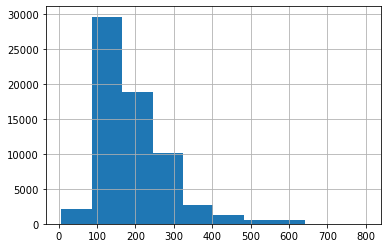

In [56]:
# Теперь, когда мы привели столбец к числовому формату посмотрим на его распределение.
united.enginePower.hist()
united.enginePower.describe()

In [57]:
num_cols.append('enginePower') # Признак числовой, добавим в соответствующий список

## Столбец fuelType (тип топлива).

In [58]:
# Проверим столбец на наличие пропусков.
united.fuelType.isna().value_counts()

False    65609
Name: fuelType, dtype: int64

In [59]:
display(united.fuelType.value_counts())
display(len(united.fuelType.value_counts()))

бензин     53453
дизель     11599
гибрид       407
электро      137
газ           13
Name: fuelType, dtype: int64

5

<AxesSubplot:>

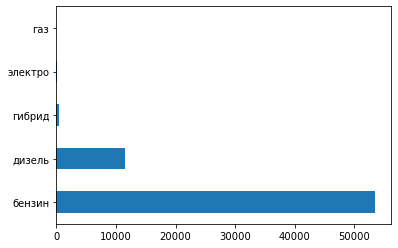

In [60]:
#посмотрим на распределение
united.fuelType.value_counts().plot.barh() 

In [61]:
cat_cols.append('fuelType') # Признак категориальный, добавим в соответствующий список

##  Столбец image (изображение).

In [62]:
#ls = united.image.tolist()
unique_or_not(united.image)

<ipython-input-2-349788707dfc>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = x[i]
<ipython-input-2-349788707dfc>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = False
<ipython-input-2-349788707dfc>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = True
<ipython-input-2-349788707dfc>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [63]:
united.image.value_counts()

True     65227
False      382
Name: image, dtype: int64

In [64]:
bin_cols.append('image') # Признак бинарный, добавим в соответствующий список

<AxesSubplot:xlabel='image', ylabel='count'>

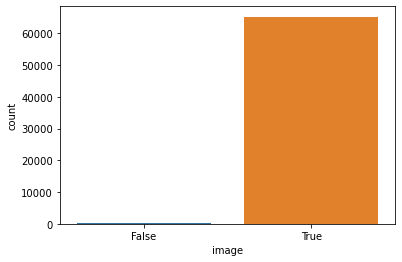

In [65]:
sns.countplot(x = 'image', data = united)

## Столбец mileage (пробег).

In [66]:
# Проверим столбец на наличие пропусков.
united.mileage.isna().value_counts()

False    65609
Name: mileage, dtype: int64

In [67]:
#Почистим данные
united['mileage'] = united['mileage'].apply(lambda x: str(x).replace('\xa0км', ''))

united['mileage'] = united.mileage.apply(
    lambda x: int("".join(filter(str.isdigit, x))))

count      65609.000000
mean      152734.059931
std        98234.485146
min            1.000000
25%        82450.000000
50%       140000.000000
75%       202667.000000
max      1000000.000000
Name: mileage, dtype: float64

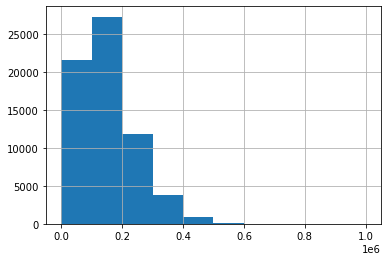

In [68]:
# Этот столбец числовой и без пропусков. Поэтому посмотрим на его распределение:
united.mileage.hist()
united.mileage.describe()

In [69]:
num_cols.append('mileage') # Признак числовой, добавим в соответствующий список

## Столбец modelDate (дата выпуска модели)

In [70]:
# Проверим столбец на наличие пропусков.
united.modelDate.isna().value_counts()

False    65609
Name: modelDate, dtype: int64

count    65609.000000
mean      2008.907878
std          7.304078
min       1904.000000
25%       2006.000000
50%       2010.000000
75%       2014.000000
max       2021.000000
Name: modelDate, dtype: float64

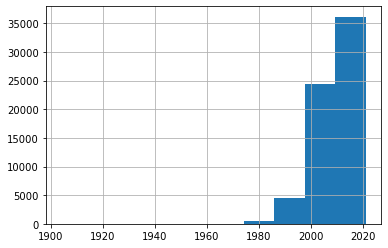

In [71]:
# Этот столбец числовой и без пропусков. Поэтому посмотрим на его распределение:
united.modelDate.hist()
united.modelDate.describe()

In [72]:
num_cols.append('modelDate') # Признак числовой, добавим в соответствующий список

## Столбец model_name (название модели).

In [73]:
# Проверим столбец на наличие пропусков.
united.model_name.isna().value_counts()

False    65609
Name: model_name, dtype: int64

In [74]:
display(united.model_name.value_counts())
display(len(united.model_name.value_counts()))

OCTAVIA                           2471
5ER                               1719
CAMRY                             1475
POLO                              1410
E_KLASSE                          1402
                                  ... 
Skoda Fabia I Рестайлинг             1
McLaren 720S                         1
Jeep Renegade I                      1
LADA (ВАЗ) 2105  21053-20            1
Chevrolet Malibu IX Рестайлинг       1
Name: model_name, Length: 2173, dtype: int64

2173

In [75]:
cat_cols.append('model_name') # Признак категориальный, добавим в соответствующий список

## Столбец name (имя).

In [76]:
# В этом признаке намешано много разной информации из других столбцов. Обработка не целесообразна. Удалим его.
del united['name']

## Столбец numberOfDoors (количество дверей).

In [77]:
# Проверим столбец на наличие пропусков.
united.numberOfDoors.isna().value_counts()

False    65609
Name: numberOfDoors, dtype: int64

In [78]:
display(united.numberOfDoors.value_counts())
display(len(united.numberOfDoors.value_counts()))

5    36866
4    25512
2     2129
3     1101
0        1
Name: numberOfDoors, dtype: int64

5

In [79]:
# Создадим словарь numberOfDoors_dict куда запишим категориальные значения, соответствующие 
# 5 (five_doors), 4 (four_doors), 3 (three_doors), 2 (two_doors), 1 (one_door) и 0 (zero_doors):
numberOfDoors_dict = {"numberOfDoors": {5: 'five_doors', 4: 'four_doors', 
                                        3: 'three_doors', 2: 'two_doors', 1: 'one_door', 0: 'zero_doors'}}# Создали словарь
united = united.replace(numberOfDoors_dict)# Заменили в столбце numberOfDoors числовые значения категориальными.

<AxesSubplot:>

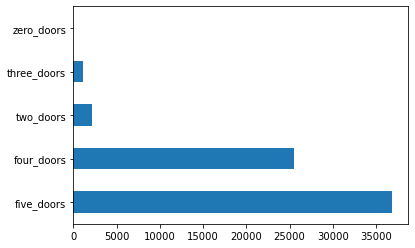

In [80]:
#посмотрим на распределение
united.numberOfDoors.value_counts().plot.barh() 

In [81]:
cat_cols.append('numberOfDoors') # Признак категориальный, добавим в соответствующий список

## Столбец priceCurrency (валюта)

In [82]:
# Проверим столбец на наличие пропусков.
united.priceCurrency.isna().value_counts()

False    65609
Name: priceCurrency, dtype: int64

In [83]:
display(united.priceCurrency.value_counts())
display(len(united.priceCurrency.value_counts()))

RUB    65609
Name: priceCurrency, dtype: int64

1

In [84]:
del united['priceCurrency']

## Столбец productionDate (год производства).

In [85]:
# Проверим столбец на наличие пропусков.
united.productionDate.isna().value_counts()

False    65609
Name: productionDate, dtype: int64

count    65609.000000
mean      2010.251840
std          6.868941
min       1904.000000
25%       2007.000000
50%       2012.000000
75%       2015.000000
max       2021.000000
Name: productionDate, dtype: float64

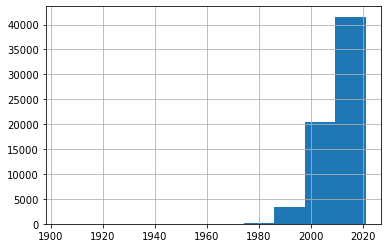

In [86]:
# Этот столбец числовой и без пропусков. Поэтому посмотрим на его распределение:
united.productionDate.hist()
united.productionDate.describe()

In [87]:
num_cols.append('productionDate') # Признак числовой, добавим в соответствующий список

## Столбцы car_age (возраст автомобиля) и model_age (возраст модели). 

In [88]:
united['car_age'] = 2021
united['model_age'] = 2021
united['car_age'] = united['car_age'] - united['productionDate']
united['model_age'] = united['model_age'] - united['modelDate']

In [89]:
num_cols.append('model_age') # Признак числовой, добавим в соответствующий список
num_cols.append('car_age') # Признак числовой, добавим в соответствующий список

## Столбец vehicleConfiguration (конфигурация транспортного средства).

In [90]:
# В этом признаке намешано много разной информации из других столбцов. Обработка не целесообразна. Удалим его.
del united['vehicleConfiguration']

## Столбец vehicleTransmission - трансмиссия

In [91]:
# Проверим столбец на наличие пропусков.
united.vehicleTransmission.isna().value_counts()

False    65609
Name: vehicleTransmission, dtype: int64

In [92]:
display(united.vehicleTransmission.value_counts())
display(len(united.vehicleTransmission.value_counts()))

автоматическая      37639
механическая        12662
роботизированная     7798
вариатор             7510
Name: vehicleTransmission, dtype: int64

4

<AxesSubplot:>

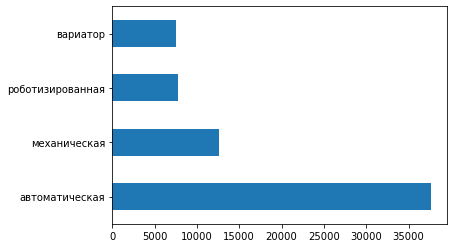

In [93]:
#посмотрим на распределение
united.vehicleTransmission.value_counts().plot.barh() 

In [94]:
cat_cols.append('vehicleTransmission') # Признак категориальный, добавим в соответствующий список

## Столбец Владельцы (кол-во владельцев).

In [95]:
# Проверим столбец на наличие пропусков.
united.Владельцы.isna().value_counts()

False    65609
Name: Владельцы, dtype: int64

count           65609
unique              5
top       3 или более
freq            27688
Name: Владельцы, dtype: object

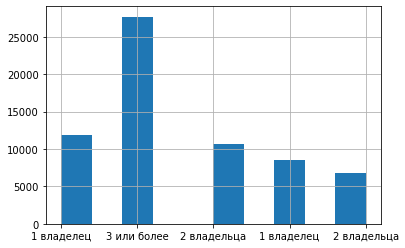

In [96]:
# Этот столбец числовой и без пропусков. Поэтому посмотрим на его распределение:
united.Владельцы.hist()
united.Владельцы.describe()

In [97]:
cat_cols.append('Владельцы') # Признак категориальный, добавим в соответствующий список

## Столбец ПТС.

In [98]:
# Проверим столбец на наличие пропусков.
united.ПТС.isna().value_counts()

False    65608
True         1
Name: ПТС, dtype: int64

In [99]:
display(united.ПТС.value_counts())
display(len(united.ПТС.value_counts()))

Оригинал    57486
Дубликат     8122
Name: ПТС, dtype: int64

2

In [100]:
united['ПТС'] = united['ПТС'].fillna('Оригинал')

In [101]:
display(united.ПТС.value_counts())
display(len(united.ПТС.value_counts()))

Оригинал    57487
Дубликат     8122
Name: ПТС, dtype: int64

2

In [102]:
bin_cols.append('ПТС') # Признак бинарный, добавим в соответствующий список

<AxesSubplot:>

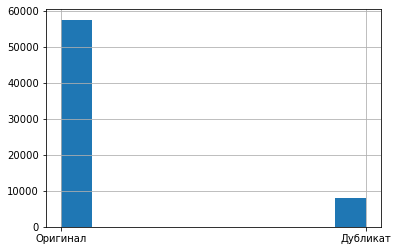

In [103]:
united.ПТС.hist()

## Столбец Привод.

In [104]:
# Проверим столбец на наличие пропусков.
united.Привод.isna().value_counts()

False    65609
Name: Привод, dtype: int64

In [105]:
display(united.Привод.value_counts())
display(len(united.Привод.value_counts()))

передний    29352
полный      29242
задний       7015
Name: Привод, dtype: int64

3

<AxesSubplot:xlabel='Привод', ylabel='count'>

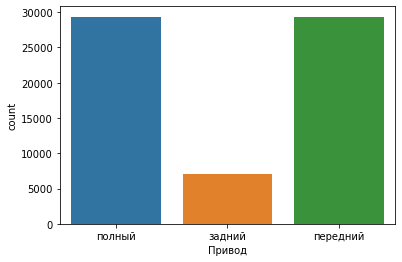

In [106]:
sns.countplot(x = 'Привод', data = united)

In [107]:
cat_cols.append('Привод') # Признак категориальный, добавим в соответствующий список

## Столбец Руль.

In [108]:
# Проверим столбец на наличие пропусков.
united.Руль.isna().value_counts()

False    65609
Name: Руль, dtype: int64

In [109]:
display(united.Руль.value_counts())
display(len(united.Руль.value_counts()))

Левый     63355
Правый     2254
Name: Руль, dtype: int64

2

<AxesSubplot:xlabel='Руль', ylabel='count'>

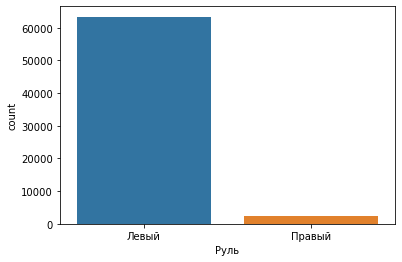

In [110]:
sns.countplot(x = 'Руль', data = united)

In [111]:
bin_cols.append('Руль') # Признак бинарный, добавим в соответствующий список

## Столбец Состояние.

In [112]:
# Проверим столбец на наличие пропусков.
united.Руль.isna().value_counts()

False    65609
Name: Руль, dtype: int64

In [113]:
display(united.Состояние.value_counts())
display(len(united.Состояние.value_counts()))

Не требует ремонта    65607
Битый / не на ходу        2
Name: Состояние, dtype: int64

2

In [114]:
bin_cols.append('Состояние') # Признак бинарный, добавим в соответствующий список

## Столбец Таможня.

In [115]:
# Проверим столбец на наличие пропусков.
united.Таможня.isna().value_counts()

False    65609
Name: Таможня, dtype: int64

In [116]:
display(united.Таможня.value_counts())
display(len(united.Таможня.value_counts()))

Растаможен    65609
Name: Таможня, dtype: int64

1

In [117]:
del united['Таможня']

## Запись датасета в файл (на всякий пожарный).

In [118]:
# Запишем датасет united в csv файл.
united.to_csv('D:\Data Scientist_Skill Factory\Folders with data/Unit_7/Project/united.csv')

In [119]:
# Импортируем из файла
united = pd.read_csv('D:\Data Scientist_Skill Factory\Folders with data/Unit_7/Project/united.csv')
united = united.drop(['Unnamed: 0'], axis=1)

In [120]:
united

,bodyType,brand,car_url,color,description_length,engineDisplacement,enginePower,fuelType,image,mileage,...,Владельцы,ПТС,Привод,Руль,Состояние,price,sell_id,dataset_mark,car_age,model_age
0,внедорожник 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/e_tron/110...,белый,1456,0.0,408.0,электро,True,885,...,1 владелец,Оригинал,полный,Левый,Не требует ремонта,0.0,1101083243,0,2,3
1,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11010431...,синий,125,0.0,170.0,электро,True,32000,...,1 владелец,Оригинал,задний,Левый,Не требует ремонта,0.0,1101043134,0,3,4
2,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11012780...,серый,1422,0.0,170.0,электро,True,51000,...,1 владелец,Оригинал,задний,Левый,Не требует ремонта,0.0,1101278018,0,7,8
3,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11002716...,белый,2681,0.0,170.0,электро,True,25000,...,1 владелец,Оригинал,задний,Левый,Не требует ремонта,0.0,1100271628,0,3,4
4,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11011745...,чёрный,740,0.0,170.0,электро,True,58500,...,1 владелец,Оригинал,задний,Левый,Не требует ремонта,0.0,1101174554,0,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65604,хэтчбек 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,красный,162,1.5,115.0,бензин,True,373317,...,3 или более,Дубликат,передний,Левый,Не требует ремонта,210000.0,0,1,22,22
65605,компактвэн,HONDA,https://auto.ru/cars/used/sale/honda/stream/11...,серебристый,989,1.7,130.0,бензин,True,311000,...,3 или более,Оригинал,передний,Правый,Не требует ремонта,330000.0,0,1,19,19
65606,седан,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,серый,398,1.8,140.0,бензин,True,196000,...,3 или более,Дубликат,передний,Левый,Не требует ремонта,430000.0,0,1,13,13
65607,хэтчбек 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,синий,208,1.4,90.0,бензин,True,350000,...,3 или более,Дубликат,передний,Левый,Не требует ремонта,135000.0,0,1,21,21


## Корелляционный анализ числовых признаков.

In [121]:
united[num_cols].corr()

,description_length,engineDisplacement,enginePower,mileage,modelDate,productionDate,model_age,car_age
description_length,1.000000,0.043211,0.122777,-0.224333,0.237463,0.239869,-0.237463,-0.239869
engineDisplacement,0.043211,1.000000,0.834305,0.006701,0.017017,0.003638,-0.017017,-0.003638
enginePower,0.122777,0.834305,1.000000,-0.191794,0.232150,0.217904,-0.232150,-0.217904
mileage,-0.224333,0.006701,-0.191794,1.000000,-0.659467,-0.687901,0.659467,0.687901
modelDate,0.237463,0.017017,0.232150,-0.659467,1.000000,0.970536,-1.000000,-0.970536
productionDate,0.239869,0.003638,0.217904,-0.687901,0.970536,1.000000,-0.970536,-1.000000
model_age,-0.237463,-0.017017,-0.232150,0.659467,-1.000000,-0.970536,1.000000,0.970536
car_age,-0.239869,-0.003638,-0.217904,0.687901,-0.970536,-1.000000,0.970536,1.000000


<AxesSubplot:>

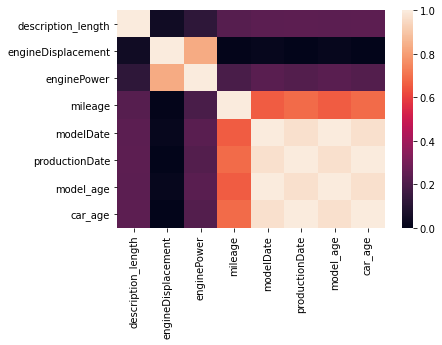

In [122]:
sns.heatmap(united[num_cols].corr().abs(), vmin=0, vmax=1)

In [123]:
test = united[united.dataset_mark == 0].drop(['dataset_mark'], axis=1) # Отделили от united тестовые данные и записали в test.

In [124]:
# Отделим от united обучающую выборку и записали в train.
train = united[united.dataset_mark == 1].drop(['dataset_mark'], axis=1) 

In [125]:
num_cols.append('price') # Добавили к списку числовых параметров цену.

In [126]:
train[num_cols].corr()

,description_length,engineDisplacement,enginePower,mileage,modelDate,productionDate,model_age,car_age,price
description_length,1.000000,0.029710,0.100021,-0.248661,0.240488,0.265530,-0.240488,-0.265530,0.236729
engineDisplacement,0.029710,1.000000,0.827731,0.009132,0.019476,0.012921,-0.019476,-0.012921,0.427583
enginePower,0.100021,0.827731,1.000000,-0.181852,0.219309,0.211810,-0.219309,-0.211810,0.600941
mileage,-0.248661,0.009132,-0.181852,1.000000,-0.671975,-0.700669,0.671975,0.700669,-0.460374
modelDate,0.240488,0.019476,0.219309,-0.671975,1.000000,0.979042,-1.000000,-0.979042,0.461866
productionDate,0.265530,0.012921,0.211810,-0.700669,0.979042,1.000000,-0.979042,-1.000000,0.470314
model_age,-0.240488,-0.019476,-0.219309,0.671975,-1.000000,-0.979042,1.000000,0.979042,-0.461866
car_age,-0.265530,-0.012921,-0.211810,0.700669,-0.979042,-1.000000,0.979042,1.000000,-0.470314
price,0.236729,0.427583,0.600941,-0.460374,0.461866,0.470314,-0.461866,-0.470314,1.000000


<AxesSubplot:>

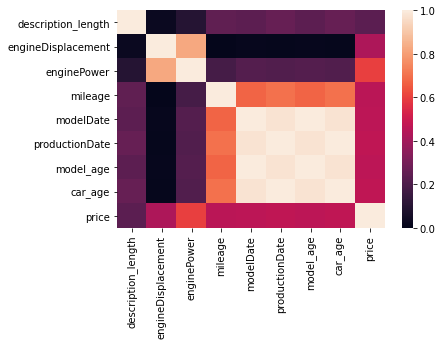

In [127]:
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1)

# Оценка значимости категориальных и бинарных признаков.

In [128]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
   
# Убедимся в преобразовании
train.head()

,bodyType,brand,car_url,color,description_length,engineDisplacement,enginePower,fuelType,image,mileage,...,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,price,sell_id,car_age,model_age
55,седан,TESLA,https://auto.ru/cars/used/sale/tesla/model_3/1...,белый,311,0.0,258.0,электро,1,15000,...,автоматическая,1 владелец,1,задний,0,1,3250000.0,0,2,4
56,лифтбек,TESLA,https://auto.ru/cars/used/sale/tesla/model_s/1...,чёрный,1015,0.0,449.0,электро,1,45000,...,автоматическая,1 владелец,1,полный,0,1,6250000.0,0,3,5
57,седан,TESLA,https://auto.ru/cars/used/sale/tesla/model_3/1...,серый,750,0.0,351.0,электро,1,11800,...,автоматическая,1 владелец,1,полный,0,1,3849000.0,0,3,4
58,седан,PORSCHE,https://auto.ru/cars/used/sale/porsche/taycan/...,белый,2503,0.0,680.0,электро,1,1426,...,автоматическая,1 владелец,1,полный,0,1,13850000.0,0,0,2
59,седан,PORSCHE,https://auto.ru/cars/used/sale/porsche/taycan/...,синий,1997,0.0,571.0,электро,1,771,...,автоматическая,1 владелец,1,полный,0,1,11900000.0,0,1,2


In [129]:
# Перекодируем категориальные признаки.
for colum in ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'Владельцы',
 'Привод']:
    train[colum] = train[colum].astype('category').cat.codes
# Убедимся в преобразовании
train.head()

,bodyType,brand,car_url,color,description_length,engineDisplacement,enginePower,fuelType,image,mileage,...,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,price,sell_id,car_age,model_age
55,14,61,https://auto.ru/cars/used/sale/tesla/model_3/1...,1,311,0.0,258.0,4,1,15000,...,0,1,1,0,0,1,3250000.0,0,2,4
56,7,61,https://auto.ru/cars/used/sale/tesla/model_s/1...,15,1015,0.0,449.0,4,1,45000,...,0,1,1,2,0,1,6250000.0,0,3,5
57,14,61,https://auto.ru/cars/used/sale/tesla/model_3/1...,12,750,0.0,351.0,4,1,11800,...,0,1,1,2,0,1,3849000.0,0,3,4
58,14,48,https://auto.ru/cars/used/sale/porsche/taycan/...,1,2503,0.0,680.0,4,1,1426,...,0,1,1,2,0,1,13850000.0,0,0,2
59,14,48,https://auto.ru/cars/used/sale/porsche/taycan/...,13,1997,0.0,571.0,4,1,771,...,0,1,1,2,0,1,11900000.0,0,1,2


<AxesSubplot:>

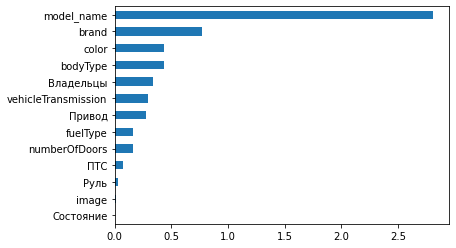

In [130]:
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['price'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [131]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])
    
# Перекодируем категориальные признаки.
for colum in ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'Владельцы',
 'Привод']:
    test[colum] = test[colum].astype('category').cat.codes

# Подготовка признаков для модели

In [132]:
num_cols

['description_length',
 'engineDisplacement',
 'enginePower',
 'mileage',
 'modelDate',
 'productionDate',
 'model_age',
 'car_age',
 'price']

In [133]:
# Создадим копию датасета train_standart, в которой стандартизируем числовые признаки и целевую переменную с помощью 
# MinMaxScaler.
train_standart = train.copy()

In [134]:
scaler = MinMaxScaler(feature_range=(0,1))
train_standart[num_cols] = scaler.fit_transform(train_standart[num_cols])

In [135]:
# Создадим копию датасета train_standart, в которой стандартизируем числовые признаки и целевую переменную с помощью 
# StandardScaler.
train_standard = train.copy()

In [136]:
scaler1 = StandardScaler()
train_standard[num_cols] = scaler1.fit_transform(train_standart[num_cols])

In [137]:
# Запишем данные из тестового набора (исключив целевую переменную price и адрес объявления в интернете и идентификатор 
# сделки) в переменную X_test_data.
X_test_data = test.drop(['car_url','price', 'sell_id'], axis=1)

In [138]:
# Разделим нестандартизированные данные на матрицу признаков X и на матрицу целевой переменной y
X = train.drop(['car_url','price', 'sell_id'], axis=1)
y = train['price']

In [139]:
# Разделим стандартизированные с помощью MinMaxScaler данные на матрицу признаков X_st и на матрицу целевой переменной y_st
X_st = train_standart.drop(['car_url','price', 'sell_id'], axis=1)
y_st = train_standart['price']

In [140]:
# Разделим стандартизированные с помощью StandardScaler данные на матрицу признаков X_stD и на матрицу целевой переменной y_stD
X_stD = train_standard.drop(['car_url','price', 'sell_id'], axis=1)
y_stD = train_standard['price']

In [141]:
# Подготовка признаков для модели завершена. Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

In [142]:
# Подготовка признаков для модели завершена. Разделим стандартизированные с помощью MinMaxScaler 
# данные для обучения следующим образом:
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X_st, y_st, test_size=0.20, shuffle=True, random_state=42)

In [143]:
# Подготовка признаков для модели завершена. Разделим стандартизированные с помощью MinMaxScaler 
# данные для обучения следующим образом:
X_stD_train, X_stD_test, y_stD_train, y_stD_test = train_test_split(X_stD, y_stD, test_size=0.20, shuffle=True, random_state=42)

# Модель 1. Создадим "наивную" модель.

In [144]:
# Разобьем датасет train.
train_train, train_test, price_train, price_test = train_test_split(train.drop(['price'], axis=1), train['price'], 
                                                    test_size=0.20, random_state=42)

In [145]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = train_test['engineDisplacement'].map(train.groupby('engineDisplacement')['price'].median())

In [146]:
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(price_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 88.79%


# Модель 2. Линейная регрессия.

In [147]:
linear_regr = LinearRegression()
linear_regr.fit(X_train,y_train)# Обучаем модель
predict = linear_regr.predict(X_test)# Предсказываем результат
#оцениваем точность
print(f"Точность модели линейной регрессии по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели линейной регрессии по метрике MAPE: 92.42%


In [148]:
linear_regr = LinearRegression()
linear_regr.fit(X_train.drop(['productionDate', 'model_age', 'car_age'], axis=1),y_train)# Обучаем модель
# Предсказываем результат
predict = linear_regr.predict(X_test.drop(['productionDate', 'model_age', 'car_age'], axis=1))
#оцениваем точность
print(f"Точность модели линейной регрессии по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели линейной регрессии по метрике MAPE: 92.03%


In [149]:
linear_regr = LinearRegression()
linear_regr.fit(X_st_train.drop(['productionDate', 'model_age', 'car_age'], axis=1),y_train)# Обучаем модель
# Предсказываем результат
predict = linear_regr.predict(X_st_test.drop(['productionDate', 'model_age', 'car_age'], axis=1))
#оцениваем точность
print(f"Точность модели линейной регрессии по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели линейной регрессии по метрике MAPE: 92.03%


In [150]:
linear_regr = LinearRegression()
linear_regr.fit(X_stD_train.drop(['productionDate', 'model_age', 'car_age'], axis=1),y_train)# Обучаем модель
# Предсказываем результат
predict = linear_regr.predict(X_stD_test.drop(['productionDate', 'model_age', 'car_age'], axis=1))
#оцениваем точность
print(f"Точность модели линейной регрессии по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели линейной регрессии по метрике MAPE: 92.03%


# Модель 3. CatBoost (из базового решения).

## Fit.

In [151]:
model_catboost_1 = CatBoostRegressor(iterations = 5000,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model_catboost_1.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model_catboost_1.save_model('catboost_single_model_baseline_1.model')

In [152]:
# оцениваем точность
predict = model_catboost_1.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 15.22%


In [153]:
model_catboost_2 = CatBoostRegressor(iterations = 5000,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model_catboost_2.fit(X_train, np.log(y_train+1),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test+1)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model_catboost_2.save_model('catboost_single_model_baseline_2.model')

In [154]:
# оцениваем точность
predict = model_catboost_2.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(predict)))*100:0.2f}%")

Точность модели по метрике MAPE: 12.81%


In [155]:
model_catboost_3 = CatBoostRegressor(iterations = 5000,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model_catboost_3.fit(X_st_train, np.log(y_train+1),
         #cat_features=cat_features_ids,
         eval_set=(X_st_test, np.log(y_test+1)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model_catboost_3.save_model('catboost_single_model_baseline_3.model')

In [156]:
# оцениваем точность
predict = model_catboost_3.predict(X_st_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(predict)))*100:0.2f}%")

Точность модели по метрике MAPE: 12.81%


In [157]:
model_catboost_4 = CatBoostRegressor(iterations = 5000,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model_catboost_4.fit(X_stD_train, np.log(y_train+1),
         #cat_features=cat_features_ids,
         eval_set=(X_stD_test, np.log(y_test+1)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model_catboost_4.save_model('catboost_single_model_baseline_4.model')

In [158]:
# оцениваем точность
predict = model_catboost_4.predict(X_stD_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(predict)))*100:0.2f}%")

Точность модели по метрике MAPE: 12.81%


# Модель 4. Random Forest.

In [159]:
rf_1 = RandomForestRegressor(random_state = 42, n_jobs = -1, verbose = 1).fit(X_train, y_train)
print(f"Точность модели по метрике MAPE: {(mape(y_test, rf_1.predict(X_test)))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s


Точность модели по метрике MAPE: 15.90%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [160]:
rf_2 = RandomForestRegressor(random_state = 42, n_jobs = -1, verbose = 1).fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf_2.predict(X_test))))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s


Точность модели по метрике MAPE: 14.38%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [161]:
rf_3 = RandomForestRegressor(random_state = 42, n_jobs = -1, verbose = 1).fit(X_st_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf_3.predict(X_st_test))))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s


Точность модели по метрике MAPE: 14.37%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [162]:
rf_4 = RandomForestRegressor(random_state = 42, n_jobs = -1, verbose = 1).fit(X_stD_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf_4.predict(X_stD_test))))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s


Точность модели по метрике MAPE: 14.37%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [163]:
# Зададим сетку гиперпараметров, которые будут перебираться:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [164]:
# Обучим наш лес (выполняется долго, будьте готовы ждать около трех часов):
rf_5 = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf_5, param_distributions=random_grid, n_iter=100, 
                              cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, np.log(y_train+1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 82.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 139.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [165]:
# Давайте посмотрим, какие гиперпараметры нам предлагают как оптимальные:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [166]:
rf_6 = RandomForestRegressor(random_state = 42, n_estimators = 800, min_samples_split = 5, min_samples_leaf = 1,
                          max_features = 'sqrt', max_depth = 90, bootstrap = False).fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf_6.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE: 13.72%


# Модель 5. Градиентный бустинг с подбором параметров.

In [167]:
# Определим функциюю подбора оптимальных параметров для градиентного бустинга.
def find_best_parameters(X_train, y_train):
    max_depth = [5, 10,15]
    n_estimators = [100, 200,1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

In [168]:
# Найдем оптимальные параметры:
best_max_depth, best_n_estimators = find_best_parameters(X_train, y_train)
best_max_depth, best_n_estimators

(5, 1000)

In [169]:
# Обучим модель градиентного буснинга с оптимальными параметрами на нестандартизированных данных.
gb_1 = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
gb_1.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb_1.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE: 13.88%


In [170]:
# Найдем оптимальные параметры:
best_max_depth, best_n_estimators = find_best_parameters(X_st_train, y_train)
best_max_depth, best_n_estimators

(5, 1000)

In [171]:
# Обучим модель градиентного буснинга с оптимальными параметрами на стандартизированных c помощью MinMaxScaler данных.
gb_2 = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
gb_2.fit(X_st_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb_2.predict(X_st_test))))*100:0.2f}%")

Точность модели по метрике MAPE: 13.87%


In [172]:
# Найдем оптимальные параметры:
best_max_depth, best_n_estimators = find_best_parameters(X_stD_train, y_train)
best_max_depth, best_n_estimators

(5, 1000)

In [173]:
# Обучим модель градиентного буснинга с оптимальными параметрами на стандартизированных c помощью StandardScaler данных.
gb_3 = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
gb_3.fit(X_stD_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb_3.predict(X_stD_test))))*100:0.2f}%")

Точность модели по метрике MAPE: 13.87%


# Модель 6. Стекинг.

In [174]:
cv = KFold(n_splits=5, shuffle=True, random_state=42) # Задали параметр кросс-валидации
# Определим функции compute_meta_feature и содержащую ее generate_meta_features. Последняя генерирует мета признаки 
# для всех объектов выборки.
def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)


    return X_meta_train, X_meta_test

def generate_meta_features(regr, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test



In [175]:
# Заменяем пропуски нулями (если где то не выявили) и возвращаем массив вместо датасета.
X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)

In [176]:
regr = RandomForestRegressor(random_state = 42, n_estimators = 1400, min_samples_split = 5, min_samples_leaf = 1,
                          max_features = 'sqrt', max_depth = 80, bootstrap = False)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000),
                            RandomForestRegressor(random_state = 42, n_jobs = -1, verbose = 1),
                            RandomForestRegressor(random_state=42, max_depth=15) \
], X_train, X_test, y_train, cv)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parall

In [177]:
def compute_metric(regr, X_train, y_train, X_test, y_test): 
    regr.fit(X_train, y_train) 
    y_test_pred = regr.predict(X_test) 
    return np.round(mape(y_test, y_test_pred)*100, 2)

print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

Точность модели по метрике MAPE: 16.14%


In [178]:
# Заменяем пропуски нулями (если где то не выявили) и возвращаем массив вместо датасета.
X_st_train = np.where(np.isnan(X_st_train), 0, X_st_train)
X_st_test = np.where(np.isnan(X_st_test), 0, X_st_test)

In [179]:
regr = RandomForestRegressor(random_state = 42, n_estimators = 1400, min_samples_split = 5, min_samples_leaf = 1,
                          max_features = 'sqrt', max_depth = 80, bootstrap = False)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000),
                            RandomForestRegressor(random_state = 42, n_jobs = -1, verbose = 1),
                            RandomForestRegressor(random_state=42, max_depth=15) \
], X_st_train, X_st_test, y_train, cv)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parall

In [180]:
print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

Точность модели по метрике MAPE: 16.03%


In [181]:
# Заменяем пропуски нулями (если где то не выявили) и возвращаем массив вместо датасета.
X_stD_train = np.where(np.isnan(X_stD_train), 0, X_stD_train)
X_stD_test = np.where(np.isnan(X_stD_test), 0, X_stD_test)

In [182]:
regr = RandomForestRegressor(random_state = 42, n_estimators = 1400, min_samples_split = 5, min_samples_leaf = 1,
                          max_features = 'sqrt', max_depth = 80, bootstrap = False)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000),
                            RandomForestRegressor(random_state = 42, n_jobs = -1, verbose = 1),
                            RandomForestRegressor(random_state=42, max_depth=15) \
], X_stD_train, X_stD_test, y_train, cv)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parall

In [183]:
print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

Точность модели по метрике MAPE: 16.12%


In [184]:
regr = RandomForestRegressor(random_state = 42, n_estimators = 1400, min_samples_split = 5, min_samples_leaf = 1,
                          max_features = 'sqrt', max_depth = 80, bootstrap = False)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000),
                            RandomForestRegressor(random_state = 42, n_jobs = -1, verbose = 1),
                            RandomForestRegressor(random_state=42, max_depth=15) \
], X_stD_train, X_stD_test, np.log(y_train+1), cv)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parall

In [185]:
regr.fit(stacked_features_train, np.log(y_train+1)) 
y_test_pred = np.exp(regr.predict(stacked_features_test))

print(f"Точность модели по метрике MAPE: {np.round(mape(y_test, y_test_pred)*100, 2)}%")

Точность модели по метрике MAPE: 14.38%


# Выводы.

# Запись в файл предсказанных алгоритмом CatBoost (с логарифмированием целевой переменной) цен для тестового набора данных.

In [186]:
# Вычисляем цены для тестового набора данных, создаем столбец test['price'] и записываем в него вычисленные цены.
y_test_data = np.exp(model_catboost_2.predict(X_test_data))
test['price'] = y_test_data

In [187]:
test

,bodyType,brand,car_url,color,description_length,engineDisplacement,enginePower,fuelType,image,mileage,...,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,price,sell_id,car_age,model_age
0,1,0,https://auto.ru/cars/used/sale/audi/e_tron/110...,1,1456,0.0,408.0,4,1,885,...,0,0,1,2,0,0,7.324612e+06,1101083243,2,3
1,23,1,https://auto.ru/cars/used/sale/bmw/i3/11010431...,13,125,0.0,170.0,4,1,32000,...,0,0,1,0,0,0,2.482559e+06,1101043134,3,4
2,23,1,https://auto.ru/cars/used/sale/bmw/i3/11012780...,12,1422,0.0,170.0,4,1,51000,...,0,0,1,0,0,0,1.691998e+06,1101278018,7,8
3,23,1,https://auto.ru/cars/used/sale/bmw/i3/11002716...,1,2681,0.0,170.0,4,1,25000,...,0,0,1,0,0,0,2.533572e+06,1100271628,3,4
4,23,1,https://auto.ru/cars/used/sale/bmw/i3/11011745...,15,740,0.0,170.0,4,1,58500,...,0,0,1,0,0,0,2.061748e+06,1101174554,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34763,15,1,https://auto.ru/cars/used/sale/bmw/3er/1101369...,6,414,1.6,136.0,0,1,115000,...,0,2,1,0,0,0,1.024826e+06,1101369263,7,10
34764,15,1,https://auto.ru/cars/used/sale/bmw/5er/1101369...,15,30,2.0,190.0,3,1,98000,...,0,0,1,2,0,0,2.386268e+06,1101369581,3,5
34765,15,1,https://auto.ru/cars/used/sale/bmw/5er/1101364...,12,17,2.5,170.0,0,1,360000,...,0,2,0,0,0,0,2.533220e+05,1101364889,24,26
34766,1,1,https://auto.ru/cars/used/sale/bmw/x1/11013625...,6,596,2.0,184.0,3,1,90500,...,0,1,1,2,0,0,1.516419e+06,1101362518,8,9


In [188]:
sample_submission

,sell_id,price
0,1100575026,0
1,1100549428,0
2,1100658222,0
3,1100937408,0
4,1101037972,0
...,...,...
34681,1101369263,0
34682,1101369581,0
34683,1101364889,0
34684,1101362518,0


In [189]:
sample_submission['price'] = test['price'] # Запишем вычисленные цены в столбец sample_submission['price'].

In [190]:
submission = sample_submission # Запишем полученный датасет в переменную submission.

In [191]:
# Запишем датасет submission в файл submission.csv.
submission.to_csv('D:\Data Scientist_Skill Factory\Folders with data/Unit_7/Project/submission.csv')